# Segundo punto

Juan Sebastian Espitia

Anamaria Irmgard Mojica 201316580

María José Ocampo 201719100

Leidy Romero Santana 201714832

### Enunciado:
Comparación de estrategias de motores de búsqueda

A continuación, implementará un motor de búsqueda con cuatro estrategias diferentes.
1. Búsqueda binaria (BS).
2. Búsqueda binaria con índice invertido (BSII)
3. Recuperación clasificada básica (RRI)
4. Recuperación clasificada y vectorización de documentos (RRDV)
Debe hacer su propia implementación utilizando numpy y pandas para manejar matrices y matrices.

Nota: Hay puntos adicionales [15p] si su implementación de "índice invertido" está distribuida (usando para
ejemplo MapReduce) o la clasificación de discos eficiente se realiza mediante BSBI. Ambas estrategias se explican en
capítulo 4 del libro https://nlp.stanford.edu/IR-book/pdf/04const.pdf.
Conjunto de datos: hay tres archivos que componen el conjunto de datos. "Docs raws texts" contiene 331 documentos en
formato NAF (XML: debe utilizar el título y el contenido para modelar cada documento). "Queries raw text" contiene
35 consultas. "relevance-judgments.tsv" contiene para cada consulta los documentos relevantes. Estos documentos relevantes fueron construidos manualmente por jueces humanos y sirven como conjunto de datos de evaluación.

Pasos de preprocesamiento: para los siguientes puntos, debe preprocesar documentos y consultas utilizando tokenización por palabra, eliminación de stop words, normalización y stemming. 

Primero se instalan los paquetes necesarios


In [26]:
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install spacy
!pip install textblob
!pip install pyspark

In [4]:
import pandas as pd
import numpy as np
import math
import re
import csv
from zipfile import ZipFile
from urllib.request import urlopen

# CARGA DE DATOS Y CONSTRUCCION DEL INDICE

In [6]:
N = 331
docs=pd.read_csv('docs.csv', sep = ';', names=['ID','lemmas']).set_index('ID')
queries=pd.read_csv('queries.csv', sep = ';', names=['ID','lemmas']).set_index('ID')

In [7]:
# Creacion del indice
indice_invertido = {} 
f = open("diccionario-lemmas-nltk.txt", "r")
for lemma in f:
  indice_invertido[lemma.replace('\n', '')]=[]

for index, row in docs.iterrows():
  lemmas=row['lemmas'].split(',')
  for lemma in lemmas:
    indice_invertido[lemma].append(index)

print(indice_invertido)    

{'theta': ['d307'], 'seminary': ['d263', 'd314'], 'scout': ['d089', 'd158', 'd158', 'd158', 'd280'], 'plumeria': ['d317', 'd317'], 'derives': ['d215'], 'unquestionable': ['d179'], 'admission': ['d039', 'd039', 'd170', 'd263'], 'action': ['d007', 'd021', 'd037', 'd072', 'd113', 'd130', 'd131', 'd134', 'd139', 'd139', 'd139', 'd158', 'd171', 'd202', 'd233', 'd254', 'd254', 'd263', 'd272', 'd286', 'd303'], 'repeat': ['d111'], 'moor': ['d228', 'd228', 'd316', 'd318', 'd318'], 'verrier': ['d140', 'd140', 'd140', 'd140', 'd140', 'd140', 'd140', 'd263'], 'gerhard': ['d058'], 'utah': ['d071', 'd138', 'd199', 'd302', 'd302', 'd312'], 'gogh': ['d109'], 'moses': ['d172'], 'stehen': ['d326'], 'lynch': ['d084'], 'ex': ['d078', 'd078', 'd160', 'd234'], 'logic': ['d005', 'd006', 'd083', 'd092', 'd092', 'd092', 'd193', 'd197', 'd202', 'd207', 'd211', 'd212', 'd212', 'd212', 'd212', 'd212', 'd212', 'd212', 'd214', 'd214', 'd215', 'd215', 'd220', 'd220', 'd220', 'd220', 'd221', 'd221', 'd224', 'd227', '

# RECUPERACION RANQUEADA BASICA (RRI)
1. Modifique el índice invertido para almacenar el tf.
2. Cree una función que lea el índice invertido modificado y calcule la puntuación del documento para una consulta determinada utilizando: 
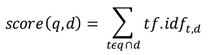
3. Para cada una de las 35 consultas del conjunto de datos, recupere los documentos clasificados -ordenados por puntuación- (incluya solo los documentos con una puntuación superior a 0 para una consulta determinada). Escriba un archivo (RRI-queries_results) con los resultados siguiendo el mismo formato que el archivo "relevance-judgments" 
4. Calcule P@M, R@M, NDCG@M por consulta. M es el número de documentos relevantes que se encuentran en el archivo de relevance-judgments por consulta. Luego calcule MAP como métrica general. 

NOTA I: Para P@M y R@M, suponga una escala de relevancia binaria. Los documentos que no se encuentran en el archivo de relevance-judgments NO son relevantes para una consulta determinada.

NOTA II: Para NDCG@M use la escala de relevancia no binaria que se encuentra en el archivo de relevance-judgments. 

In [30]:
# 1. Se modifica el indice para almacenar tf
for lemma in indice_invertido.keys():
  dict_aux={i:indice_invertido[lemma].count(i) for i in indice_invertido[lemma]}
  indice_invertido[lemma]=dict_aux

print(indice_invertido)

{'theta': {'d307': 1}, 'seminary': {'d263': 1, 'd314': 1}, 'scout': {'d089': 1, 'd158': 3, 'd280': 1}, 'plumeria': {'d317': 2}, 'derives': {'d215': 1}, 'unquestionable': {'d179': 1}, 'admission': {'d039': 2, 'd170': 1, 'd263': 1}, 'action': {'d007': 1, 'd021': 1, 'd037': 1, 'd072': 1, 'd113': 1, 'd130': 1, 'd131': 1, 'd134': 1, 'd139': 3, 'd158': 1, 'd171': 1, 'd202': 1, 'd233': 1, 'd254': 2, 'd263': 1, 'd272': 1, 'd286': 1, 'd303': 1}, 'repeat': {'d111': 1}, 'moor': {'d228': 2, 'd316': 1, 'd318': 2}, 'verrier': {'d140': 7, 'd263': 1}, 'gerhard': {'d058': 1}, 'utah': {'d071': 1, 'd138': 1, 'd199': 1, 'd302': 2, 'd312': 1}, 'gogh': {'d109': 1}, 'moses': {'d172': 1}, 'stehen': {'d326': 1}, 'lynch': {'d084': 1}, 'ex': {'d078': 2, 'd160': 1, 'd234': 1}, 'logic': {'d005': 1, 'd006': 1, 'd083': 1, 'd092': 3, 'd193': 1, 'd197': 1, 'd202': 1, 'd207': 1, 'd211': 1, 'd212': 7, 'd214': 2, 'd215': 2, 'd220': 4, 'd221': 2, 'd224': 1, 'd227': 7, 'd248': 1, 'd260': 4, 'd266': 5, 'd279': 1, 'd306': 1}

In [31]:
# 2. Se crea la funcion
def score(queryID, docID):
  tf_idf_sum=0

  doc_lemmas = set(docs.loc[docID]['lemmas'].split(","))
  query_lemmas = set(queries.loc[queryID]['lemmas'].split(","))
  lemmas = doc_lemmas.intersection(query_lemmas)
  
  for lemma in lemmas:
    tf = indice_invertido[lemma][docID]
    df = sum(indice_invertido[lemma].values())
    tf_idf_sum += math.log10( 1 + tf ) * math.log10( N / df )

  return tf_idf_sum

In [32]:
# 3. se calcula el score para cada par (query, doc) y se almacenan los resultados mayores a 0
resultados={}
for indexQ, rowQ in queries.iterrows():
  for indexD, rowD in docs.iterrows():
    puntuacion=score(indexQ, indexD)
    if puntuacion>0:
      if indexQ not in resultados.keys():
        resultados[indexQ]=[]

      resultados[indexQ].append((indexD,round(puntuacion,4)))

# Se ordenan los resultados
for i in resultados.values():
  i.sort(key = lambda x: x[1], reverse = True)

# Se escribe el archivo RRI-queries_results
with open('/content/RRI-queries_results.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    for item in resultados.items():
      tsv_writer.writerow([item[0], re.sub(r'[\[\]\(\)\ ]', '', str(item[1]).replace("',",":").replace("'",""))])

In [33]:
# 4. Calcule P@M (relevancia binaria), R@M (relevancia binaria), NDCG@M y MAP por consulta,
# M numero de documentos relevantes.

# Lectura de relevance-judgments
request_url_3 = urlopen('https://github.com/LeidyRomero/data_nlp/raw/main/HW01/relevance-judgments.tsv') 
z3 = request_url_3.read()

f = open("/content/relevance-judgments.tsv", "wb")
f.write(z3)
f.close()

tsv = open("/content/relevance-judgments.tsv","r")
read_tsv = csv.reader(tsv, delimiter="\t")

sum_avg_precision = 0
Q = 46

for row in read_tsv:
  #query
  print('-'*50)
  print('-'*23+row[0]+'-'*23)
  print('-'*50)
  #docs rel
  #print(row[1])
  M = len(row[1].split(","))
  #docs rel
  rel = {}
  for r in row[1].split(","):
    rel[r.split(":")[0]] = r.split(":")[1]
  rel_docs=list(rel.keys())

  #docs ret
  ret = [i[0] for i in resultados.get(row[0])[:M]]
  
  DCG_ACUM = 0
  BEST_DCG_ACUM = 0

  #BEST DCG
  BEST_DCG = list(rel.values())
  BEST_DCG.sort(reverse = True)
  #print(BEST_DCG)
  
  sum_precision = 0
  cont_precision = 0
  numerador = None
  antiguo_numerador = None

  for i in range(0,M):
    if numerador is not None:
      antiguo_numerador = numerador

    numerador = [value for value in rel_docs[:i+1] if value in ret[:i+1]] 

    if antiguo_numerador is not None and len(antiguo_numerador)!=len(numerador):
      sum_precision += len(numerador)/(i+1)
      print('entra')

    print('Rel = '+str(rel_docs[:i+1])+', Ret = '+str(ret[:i+1]))
    print('P@'+str(i+1)+': '+str(len(numerador)/(i+1)))
    print('R@'+str(i+1)+': '+str(len(numerador)/M))
    
    discount_factor = 1/(np.log2(np.max(np.array([i+1,2]))))
    #DCG 
    rel_i = rel.get(ret[i])
    if rel_i is not None:
      DCG_ACUM += discount_factor*int(rel_i)
    
    #BEST_DCG_2
    BEST_DCG_ACUM += discount_factor*int(BEST_DCG[i])

    print('NDCG@'+str(i+1)+': '+str(DCG_ACUM/BEST_DCG_ACUM))

  print('-'*20)
  sum_avg_precision += sum_precision/M
print('MAP: '+ str(sum_avg_precision/Q))
tsv.close()

--------------------------------------------------
-----------------------q01-----------------------
--------------------------------------------------
Rel = ['d186'], Ret = ['d085']
P@1: 0.0
R@1: 0.0
NDCG@1: 0.0
entra
Rel = ['d186', 'd254'], Ret = ['d085', 'd254']
P@2: 0.5
R@2: 0.3333333333333333
NDCG@2: 0.5
entra
Rel = ['d186', 'd254', 'd016'], Ret = ['d085', 'd254', 'd016']
P@3: 0.6666666666666666
R@3: 0.6666666666666666
NDCG@3: 0.6511363564253769
--------------------
--------------------------------------------------
-----------------------q02-----------------------
--------------------------------------------------
Rel = ['d136'], Ret = ['d147']
P@1: 0.0
R@1: 0.0
NDCG@1: 0.5
Rel = ['d136', 'd139'], Ret = ['d147', 'd283']
P@2: 0.0
R@2: 0.0
NDCG@2: 0.75
Rel = ['d136', 'd139', 'd143'], Ret = ['d147', 'd283', 'd149']
P@3: 0.0
R@3: 0.0
NDCG@3: 0.6900468833579672
entra
Rel = ['d136', 'd139', 'd143', 'd283'], Ret = ['d147', 'd283', 'd149', 'd293']
P@4: 0.25
R@4: 0.09090909090909091
NDCG@